In [1]:
import uavgeo as ug
import geopandas as gpd
import rioxarray
import numpy as np
import ultralytics
import xarray as xr
import matplotlib.pyplot as plt
import cv2

# Geographic DATASET TRAIN/VAL/TEST Splitting
For pix2pix we want a style a and style b dataset: so we create an RGB and NDVI dataset. splitted on chips in the larger orthomosaic.

This requires 3 steps:
1. Loading data
2. Defining the splits in space
3. chipping the dataset and saving the imgs to disk

## 1. Loading datasets
Load the orthomosaic
and some other geopgrahic data, in which the quality is 100% sure: the three rows of the vineyard that are covered by the flight path.



In [2]:
ortho = ug.load.load_sfm("botrytis_data/ortho_etrs89.tif", xr_name = "ms_sfm")
trunks = gpd.read_file("botrytis_data/trunks/Trunks.shp")
gcps = gpd.read_file("botrytis_data/gcps/GCPs.shp")
clusters = gpd.read_file("botrytis_data/clusters/Botrytis_clusters.shp")

# I hate shp with a passion, so lets export those real quick to a real dataformat: geojson!

trunks.to_file("botrytis_data/trunks/trunks.geojson")
gcps.to_file("botrytis_data/gcps/gcps.geojson")  
clusters.to_file("botrytis_data/clusters/clusters.geojson")

In [3]:
def scale_band_to_min_max(band, min,max, clip =True):

    if clip:
        band = band.clip(min = min, max=max)
        
    band = band.astype(float)
    band = (band-min) * (255/(max-min))
    return band.astype(np.uint8)

In [4]:
# gotta scale the input rastser to have nice RGB values:
# exploreation in QGIS seems like the following RGB max-values:
r = 7500
g = 7500
b = 6000

r_new = scale_band_to_min_max(ortho.sel(band=3), min = 0, max = r)
g_new = scale_band_to_min_max(ortho.sel(band=2), min = 0, max = g)
b_new = scale_band_to_min_max(ortho.sel(band=1), min = 0, max = b)
da = xr.combine_nested([r_new, g_new, b_new],concat_dim = "band")

In [ ]:
#calc ndvi
ndvi = ug.compute.calc_ndvi(ortho,red_id =3, nir_id=4, rescale= True)

### Train / val / test splits

The train and val splits are with input_overlap at 128, whilst test is without: so the dataset is passed through the following bit twice.

In [ ]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x": 256, "y":256}
input_overlap = {"x": 128, "y":128} # change this to 0 for the test-set

#shape (resolution) of input image
shape = ortho_8.shape
c = ortho_8.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(ortho_8, x)) 

In [ ]:
# need to clip to the best possible dataset-section: which is in the bounds of the trunks + 3meter
expand = 3

minx = trunks.geometry.x.min()
miny = trunks.geometry.y.min()
maxx = trunks.geometry.x.max()
maxy = trunks.geometry.y.max()

y = trunks.geometry.y[trunks.geometry.x==minx]
bl = (minx-expand,y-expand) 

x = trunks.geometry.x[trunks.geometry.y==maxy]
tl = (x-expand, maxy+expand)

y = trunks.geometry.y[trunks.geometry.x==maxx]
tr = (maxx+expand, y+expand)

x = trunks.geometry.x[trunks.geometry.y==miny]
br = (x+expand,miny-expand )


from shapely import Polygon

p = Polygon([bl,tl, tr,br])

In [ ]:
# find all chips that are within the intersection between the trunks-geom and themselves
chippies = chips.set_geometry(chips["crs_geom"])
trunk_outline = gpd.GeoSeries(p,crs = ortho.rio.crs)
chippies["intersects"] = chippies["geometry"].apply(lambda x: trunk_outline.intersects(x))
chippies = chippies[chippies["intersects"]].copy()
print(len(chippies))
# now split the dataset into train/test/val


In [ ]:
# THis section is ran twice for the different overlaps :) Ensure that you only overwrite the test-one

In [ ]:
# split the dataset into a top third, and two third bottom
# where validation will be 1/4 of train.
test_size = int(len(chippies)/3)
print("TEST SIZE: ", test_size, "TOTAL: ", len(chippies))
test = chippies.iloc[0:test_size].copy() 
train = chippies.iloc[test_size:].copy()

val_size = int(len(train)/4)
val = train.iloc[0:val_size].copy()

train = train.iloc[val_size:].copy()

print("VAL SIZE: ", val_size, "TRAIN: ", len(train))

print("checks out? ", len(test), len(val), len(train), "==", len(chippies))

In [ ]:
# cross-contamination between the edges is illegal:
train["intersects_val"] = train["geometry"].apply(lambda x: val.dissolve().geometry.intersects(x))
train = train[train["intersects_val"]==False].copy()
val["intersects_train"] = val["geometry"].apply(lambda x: train.dissolve().geometry.intersects(x))
val["intersects_test"] = val["geometry"].apply(lambda x: test_bup.dissolve().geometry.intersects(x))
val = val[val["intersects_train"]==False].copy()
val = val[val["intersects_test"]==False].copy()

In [ ]:
#saveit to disk
train.drop(columns = ["crs_geom"]).to_file("botrytis_data/p2p_geoms/train.geojson")
val.drop(columns = ["crs_geom"]).to_file("botrytis_data/p2p_geoms/val.geojson")
test_bup.drop(columns = ["crs_geom"]).to_file("botrytis_data/p2p_geoms/test.geojson")

## 2. Visualizing

Let's visualize what we actually did.

In [5]:
# load the datasplits 

train = gpd.read_file("botrytis_data/p2p_geoms/train.geojson")
test = gpd.read_file("botrytis_data/p2p_geoms/test.geojson")
val = gpd.read_file("botrytis_data/p2p_geoms/val.geojson")


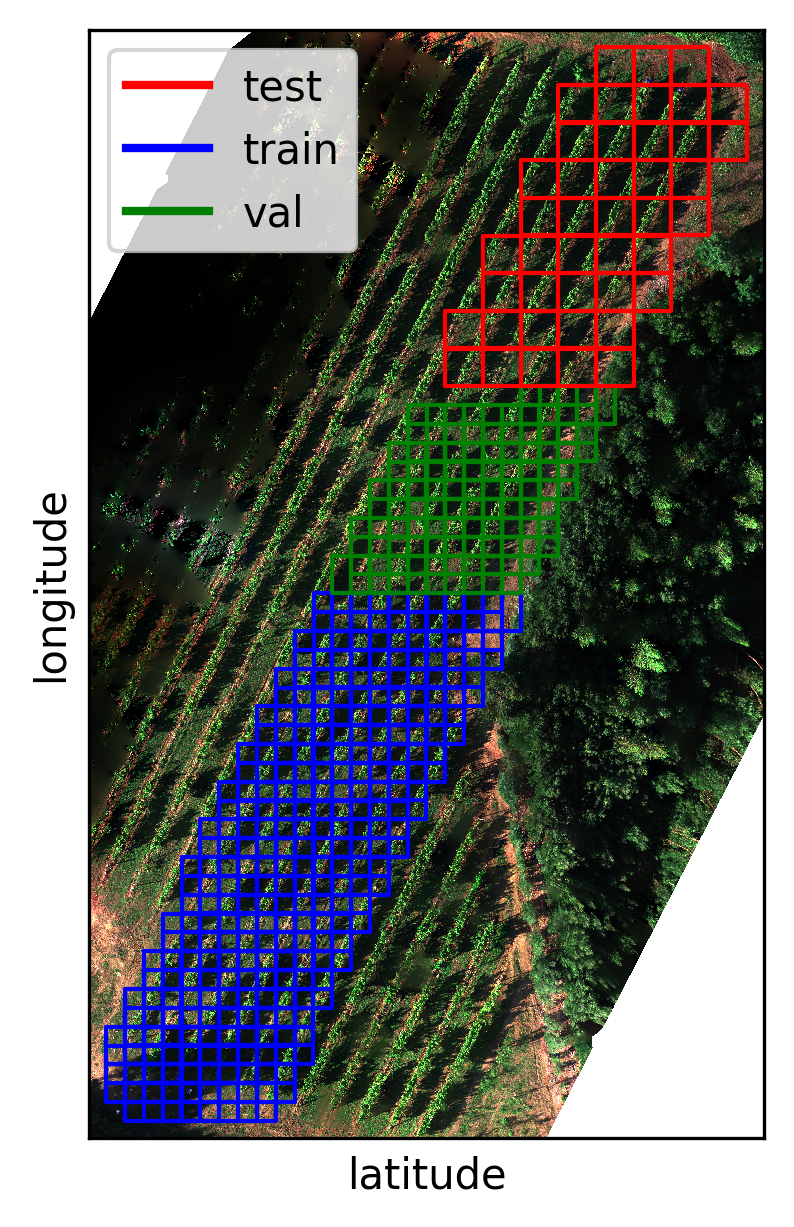

In [17]:
fig, ax = plt.subplots(dpi = 300)

da.plot.imshow(ax=ax)
ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

train.plot(ax=ax, facecolor= "none", edgecolor= 'blue' ,label="train")
val.plot(ax=ax, facecolor= "none", edgecolor= 'green', label= "val" )
test.plot(ax=ax, facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax.set_ylim((train.geometry.bounds.min().miny-2,test.geometry.bounds.max().maxy+2))

ax.set_xlim(((train.geometry.bounds.min().minx-2,test.geometry.bounds.max().maxx+2)))

# Create custom legend labels and colors using patches
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='test'),
    plt.Line2D([0], [0], color='blue', lw=2, label='train'),
    plt.Line2D([0], [0], color='green', lw=2, label='val')
]

plt.legend(handles=legend_elements, loc= "upper left")

plt.savefig("figures/traintestval.png", dpi =300)
plt.show()

## 3. Actual subsetting of the imagery 
Requires the orthomosaic, coloured to nice colours and called 'da', see above.

#### Starting with the RGB: style A

In [ ]:
#clip RGB set:

val_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in val.iterrows()]
train_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in train.iterrows()]
test_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in test.iterrows()]


In [ ]:
# transpose to RGB instead of BANDS
val_rgbs = [np.transpose(img.values, (1,2,0)) for img in val_rgbs]
train_rgbs = [np.transpose(img.values, (1,2,0)) for img in train_rgbs]
test_rgbs = [np.transpose(img.values, (1,2,0)) for img in test_rgbs]


In [ ]:
# augment the validation and train set, NOT THE TEST SET: THATS ILLEGAL

# rotate 
rot_val_rgbs = [np.rot90(img) for img in val_rgbs]
rot_train_rgbs = [np.rot90(img) for img in train_rgbs]
# flip 
flip_val_rgbs = [np.flip(img,axis=1) for img in val_rgbs]
flip_train_rgbs = [np.flip(img,axis=1) for img in train_rgbs]

val_set = val_rgbs + rot_val_rgbs + flip_val_rgbs
train_set = train_rgbs + rot_train_rgbs + flip_train_rgbs

#### repeat for NDVI: Style B

In [ ]:
#clip NDVI set

val_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in val.iterrows()]
train_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in train.iterrows()]
test_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in test.iterrows()]


In [ ]:
# transpose to ndvi img
val_ndvi = [img.values for img in val_ndvi]
train_ndvi = [img.values for img in train_ndvi]
test_ndvi = [img.values for img in test_ndvi]

In [ ]:
# rotate 
rot_val_ndvi = [np.rot90(img) for img in val_ndvi]
rot_train_ndvi = [np.rot90(img) for img in train_ndvi]
# flip 
flip_val_ndvi = [np.flip(img,axis=1) for img in val_ndvi]
flip_train_ndvi = [np.flip(img,axis=1) for img in train_ndvi]

val_set_ndvi = val_ndvi + rot_val_ndvi + flip_val_ndvi
train_set_ndvi = train_ndvi + rot_train_ndvi + flip_train_ndvi

In [ ]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [ ]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("botrytis_data", "p2p")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "A", "test")
export_image_list(test_path, test_rgbs)

train_path = os.path.join(path, "A", "train")
export_image_list(train_path, train_set)

val_path = os.path.join(path, "A", "val")
export_image_list(val_path, val_set)

#for style B: aka ndvi
test_path = os.path.join(path, "B", "test")
export_image_list(test_path, test_ndvi)

train_path = os.path.join(path, "B", "train")
export_image_list(train_path, train_set_ndvi)

val_path = os.path.join(path, "B", "val")
export_image_list(val_path, val_set_ndvi)